<a href="https://colab.research.google.com/github/KarimSalem9000/cs370/blob/main/Copy_of_5_2_using_convnets_with_small_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pantelis/aiml-common/blob/master/lectures/cnn/cnn-example-architectures/using_convnets_with_small_datasets.ipynb)


This notebook is by F. Chollet and is included in his book.

In [4]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'

import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


# Using convnets with small datasets

This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer
vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision
competition in late 2013, back when convnets weren't quite mainstream. The data in the form of a zip file is stored in your course repo under the path

```lectures/cnn/cnn-example-architectures/dogs-vs-cats-subset.zip```

<!-- You can download the original dataset at:
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the
process is painless). -->

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [5]:
import os, shutil

In [6]:
# Unzip file
!mkdir -p dogscats/subset
!unzip -o -q dogs-vs-cats-subset.zip -d dogscats


In [7]:
base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')




So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [8]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to
use in various situations).

In [10]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we
will use here.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop
at some point.

In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does.
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case,
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument,
which tells the process how many batches to draw from the validation generator for evaluation.

In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30


<ipython-input-13-a7acfc8093a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 16s 52ms/step - loss: 0.7018 - acc: 0.5025 - val_loss: 0.6893 - val_acc: 0.5980
Epoch 2/30
100/100 [==============================] - 9s 90ms/step - loss: 0.6956 - acc: 0.5180 - val_loss: 0.6859 - val_acc: 0.5690
Epoch 3/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6844 - acc: 0.5690 - val_loss: 0.6437 - val_acc: 0.6380
Epoch 4/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6460 - acc: 0.6380 - val_loss: 0.6068 - val_acc: 0.6680
Epoch 5/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5859 - acc: 0.7040 - val_loss: 0.6375 - val_acc: 0.6230
Epoch 6/30
100/100 [==============================] - 6s 61ms/step - loss: 0.5504 - acc: 0.7175 - val_loss: 0.5677 - val_acc: 0.7100
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 0.5164 - acc: 0.7445 - val_loss: 0.5473 - val_acc: 0.7330
Epoch 8/30
100/100 [==============================] - 5s 55ms/step - loss: 0.47

It is good practice to always save your models after training:

In [14]:
model.save('cats_and_dogs_small_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's plot the loss and accuracy of the model over the training and validation data during training:

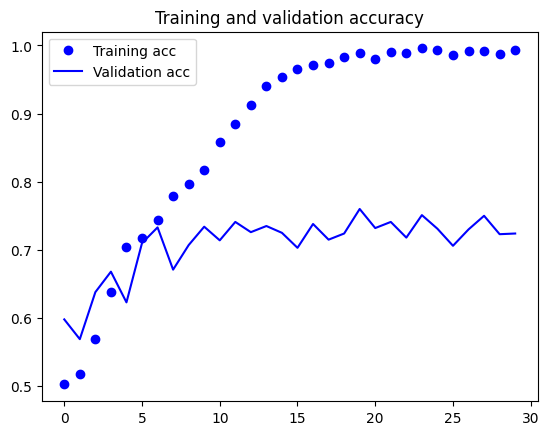

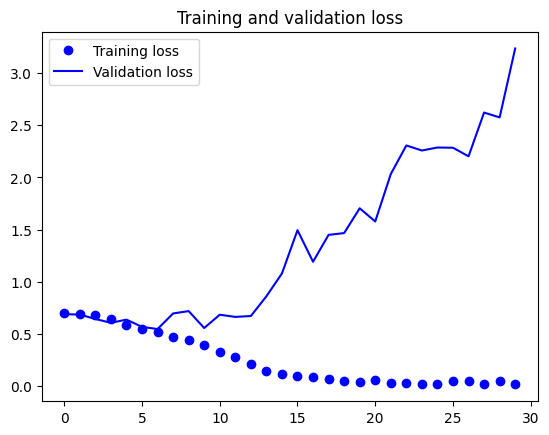

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator`
instance. Let's get started with an example:

In [16]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

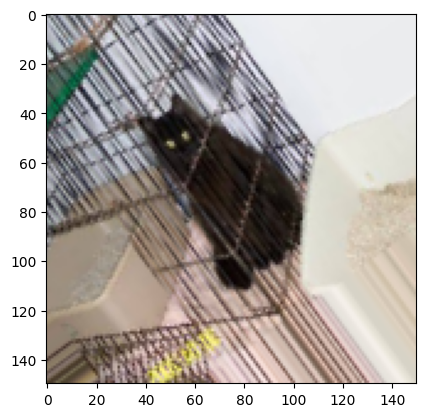

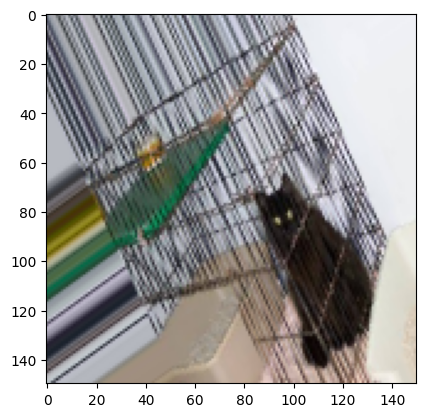

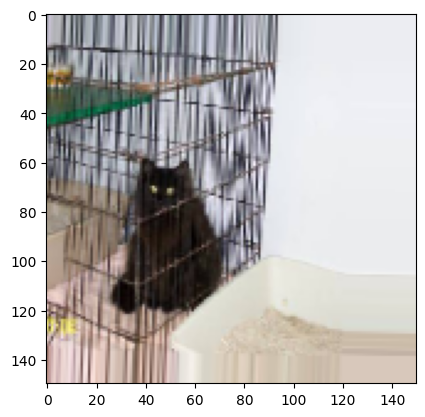

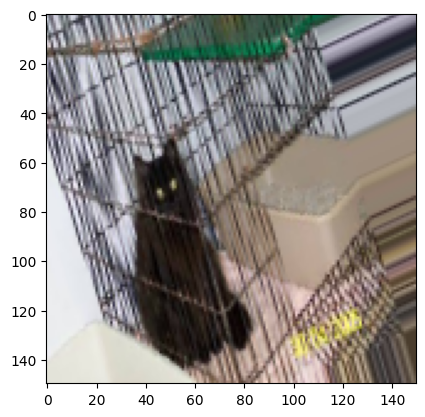

In [17]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
62/62 [==============================] - 18s 259ms/step - loss: 0.6962 - acc: 0.5086 - val_loss: 0.6917 - val_acc: 0.4990
Epoch 2/100
62/62 [==============================] - 16s 253ms/step - loss: 0.6961 - acc: 0.4929 - val_loss: 0.6914 - val_acc: 0.6119
Epoch 3/100
62/62 [==============================] - 16s 253ms/step - loss: 0.6929 - acc: 0.5315 - val_loss: 0.6820 - val_acc: 0.5252
Epoch 4/100
62/62 [==============================] - 16s 254ms/step - loss: 0.6752 - acc: 0.6103 - val_loss: 0.6979 - val_acc: 0.5192
Epoch 5/100
62/62 [==============================] - 15s 248ms/step - loss: 0.6651 - acc: 0.6123 - val_loss: 0.6194 - val_acc: 0.6683
Epoch 6/100
62/62 [==============================] - 16s 257ms/step - loss: 0.6507 - acc: 0.6265 - val_loss: 0.6310 - val_acc: 0.6411
Epoch 7/100
62/62 [==============================] - 16s 256ms/step - loss: 0.6298 - acc: 0.6443 - val_loss: 0.6

Let's save our model -- we will be using it in the section on convnet visualization.

In [20]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

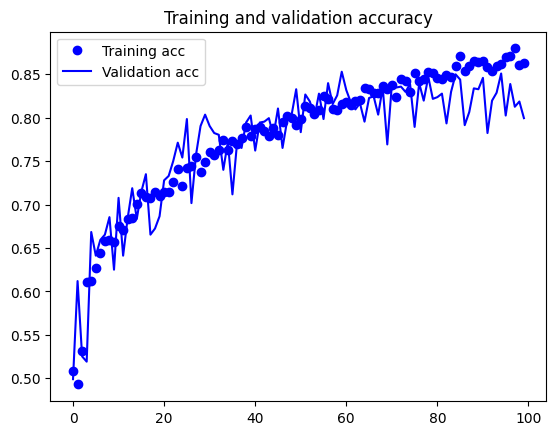

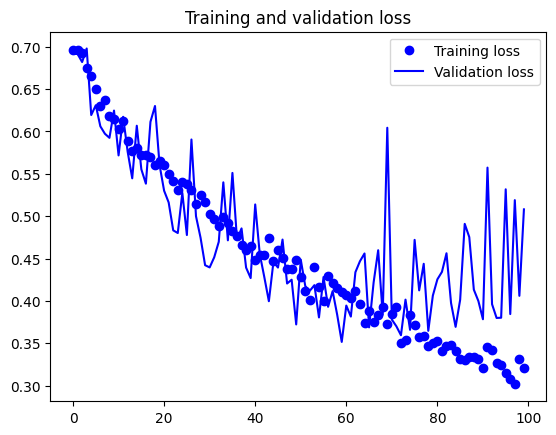

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

32/32 [==============================] - 2s 57ms/step


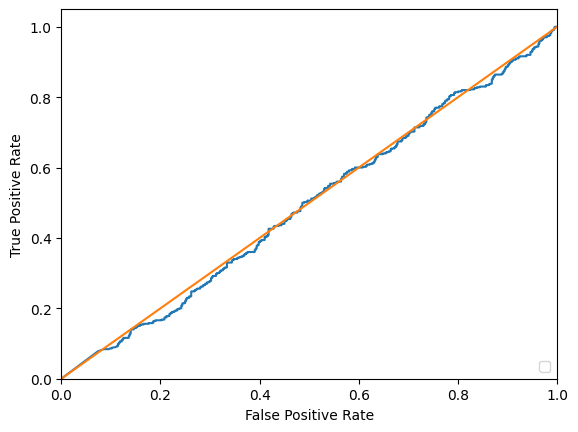

In [22]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

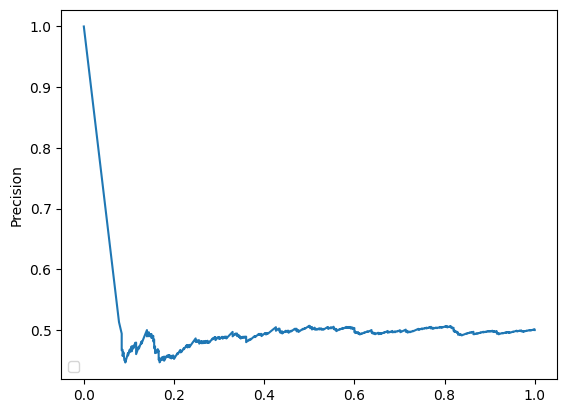

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

plt.figure()
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


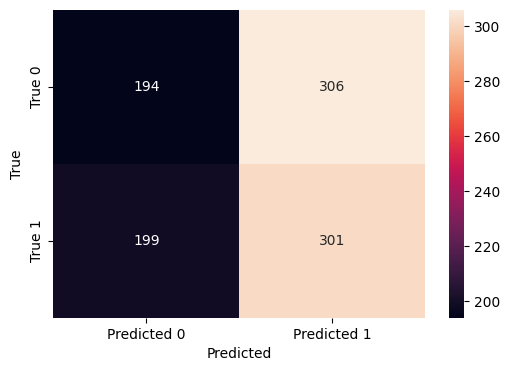

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

conf_matrix = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
